# RNN Assignment

In [1]:
#### PACKAGE IMPORTS ####
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Load Data

In [2]:
# Load the text file into a string

with open('../input/shakespeare-text/text.txt', 'r', encoding='utf-8') as file:
    text = file.read()
    
# please notice that if you want to load it on following code should be used instead:
#    from google.colab import drive
#    drive.mount('/content/gdrive')

In [3]:
text_chunks = text.split('.')

### A piece of data

In [4]:
# Display some randomly selected text samples

num_samples = 5
inx = np.random.choice(len(text_chunks), num_samples, replace=False)
for chunk in np.array(text_chunks)[inx]:
    print(chunk)


Lo, this is all:--nay, yet depart not so;
Though this be all, do not so quickly go;
I shall remember more


QUEEN ELIZABETH:
But how long fairly shall her sweet lie last?

KING RICHARD III:
So long as heaven and nature lengthens it


DORCAS:
He hath promised you more than that, or there be liars


HASTINGS:
My liege, I'll knock once more to summon them


ESCALUS:
Come hither to me, Master Elbow; come hither, Master
constable


#### Create a character-level tokenizer

In [5]:
def create_character_tokenizer(list_of_strings):
    """
    This function takes a list of strings as its argument. It should create 
    and return a Tokenizer according to the above specifications. 
    """
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
          num_words=10000,
          filters =None,
          lower = False,
          split =None,
          char_level = True,
          oov_token = 'OOV',
          document_count = 0
) 
    tokenizer.fit_on_texts(list_of_strings)
    return tokenizer

In [6]:
# Get the tokenizer

tokenizer = create_character_tokenizer(text_chunks)

#### Tokenize the text

 [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) for the `Tokenizer`.
 

In [7]:
def strings_to_sequences(tokenizer, list_of_strings):
    """
    This function takes a tokenizer object and a list of strings as its arguments.
    It should use the tokenizer to map the text chunks to sequences of tokens and
    then return this list of encoded sequences.
    """
    sentence_seq = tokenizer.texts_to_sequences(list_of_strings)
    return sentence_seq
    

In [8]:
# Encode the text chunks into tokens

seq_chunks = strings_to_sequences(tokenizer, text_chunks)
# seq_chunks

#### Pad the encoded sequences and store them in a numpy array


**Hint:** you may want to refer to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) for the `pad_sequences` function.

In [9]:


def make_padded_dataset(sequence_chunks):
    """
    This function takes a list of lists of tokenized sequences, and transforms
    them into a 2D numpy array, padding the sequences as necessary according to
    the above specification. The function should then return the numpy array.
    """
    padded_x_train = tf.keras.preprocessing.sequence.pad_sequences(sequence_chunks,
                                              maxlen = 500,
                                              dtype = 'int32',
                                              padding = 'pre',
                                              truncating = 'pre',
                                              value=0.0)
    return padded_x_train
    

In [10]:
def create_inputs_and_targets(array_of_sequences):
    """
    This function takes a 2D numpy array of token sequences, and returns a tuple of two
    elements: the first element is the input array and the second element is the output
    array, which are defined according to the specification.
    """   
    input_seq = array_of_sequences[:, :-1]
    output_seq = array_of_sequences[:, 1:]
    return input_seq, output_seq

In [11]:
# Pad the token sequence chunks and get the numpy array

padded_sequences = make_padded_dataset(seq_chunks)

#### Create model inputs and targets



In [12]:
def create_inputs_and_targets(array_of_sequences):
    """
    This function takes a 2D numpy array of token sequences, and returns a tuple of two
    elements: the first element is the input array and the second element is the output
    array, which are defined according to the above specification.
    """   
    input_seq = array_of_sequences[:, :-1]
    output_seq = array_of_sequences[:, 1:]
    return input_seq, output_seq
    

In [13]:
# Create the input and output arrays

input_seq, target_seq = create_inputs_and_targets(padded_sequences)

#### Preprocess sequence array for stateful RNN



In [14]:
# Fix the batch size for training

batch_size = 32

In [15]:
# Prepare input and output arrays for training the stateful RNN

num_examples = input_seq.shape[0]

num_processed_examples = num_examples - (num_examples % batch_size)

input_seq = input_seq[:num_processed_examples]
target_seq = target_seq[:num_processed_examples]

steps = int(num_processed_examples / 32)  # steps per epoch

inx = np.empty((0,), dtype=np.int32)
for i in range(steps):
    inx = np.concatenate((inx, i + np.arange(0, num_processed_examples, steps)))

input_seq_stateful = input_seq[inx]
target_seq_stateful = target_seq[inx]

#### Split the data into training and validation sets

set aside 20% of the data for validation set

In [16]:
# Create the training and validation splits

num_train_examples = int(batch_size * ((0.8 * num_processed_examples) // batch_size))

input_train = input_seq_stateful[:num_train_examples]
target_train = target_seq_stateful[:num_train_examples]

input_valid = input_seq_stateful[num_train_examples:]
target_valid = target_seq_stateful[num_train_examples:]

#### Create training and validation Dataset objects



In [17]:
def make_Dataset(input_array, target_array, batch_size):
    """
    This function takes two 2D numpy arrays in the first two arguments, and an integer
    batch_size in the third argument. It should create and return a Dataset object 
    using the two numpy arrays and batch size according to the above specification.
    """
    dataset = tf.data.Dataset.from_tensor_slices((input_array, target_array))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset
    

In [18]:
# Create the training and validation Datasets

train_data = make_Dataset(input_train, target_train, batch_size)
valid_data = make_Dataset(input_valid, target_valid, batch_size)

#### Build the recurrent neural network model

In [42]:
def get_model(vocab_size, batch_size):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    model = tf.keras.Sequential(
        [
         tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True, batch_input_shape=(batch_size, None)),
         tf.keras.layers.LSTM(1024,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
#          tf.keras.layers.LSTM(1024,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
         tf.keras.layers.Dense(vocab_size)
        ]
    )
    
    return model
    

In [43]:
# Build the model and print the model summary

model = get_model(len(tokenizer.word_index) + 1, batch_size)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (32, None, 256)           16896     
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
lstm_3 (LSTM)                (32, None, 1024)          8392704   
_________________________________________________________________
dense_4 (Dense)              (32, None, 66)            67650     
Total params: 13,724,226
Trainable params: 13,724,226
Non-trainable params: 0
_________________________________________________________________


#### Compile and train the model



In [44]:
# Choose whether to train a new model or load the pre-trained model

skip_training = False

In [46]:
# Compile and train the model, or load pre-trained weights

if not skip_training:
    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./models/ckpt',
                                                           save_weights_only=True,
                                                           save_best_only=True)
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['sparse_categorical_accuracy'])
    history = model.fit(train_data, epochs=15, validation_data=valid_data, 
                        validation_steps=50, callbacks=[checkpoint_callback])

Epoch 1/15
196/196 [==============================] - 209s 1s/step - loss: 0.8629 - sparse_categorical_accuracy: 0.1863 - val_loss: 0.5939 - val_sparse_categorical_accuracy: 0.3833
Epoch 2/15
196/196 [==============================] - 203s 1s/step - loss: 0.5407 - sparse_categorical_accuracy: 0.4223 - val_loss: 0.4676 - val_sparse_categorical_accuracy: 0.5022
Epoch 3/15
196/196 [==============================] - 202s 1s/step - loss: 0.4381 - sparse_categorical_accuracy: 0.5216 - val_loss: 0.4162 - val_sparse_categorical_accuracy: 0.5503
Epoch 4/15
196/196 [==============================] - 202s 1s/step - loss: 0.3906 - sparse_categorical_accuracy: 0.5674 - val_loss: 0.3940 - val_sparse_categorical_accuracy: 0.5708
Epoch 5/15
196/196 [==============================] - 202s 1s/step - loss: 0.3623 - sparse_categorical_accuracy: 0.5936 - val_loss: 0.3831 - val_sparse_categorical_accuracy: 0.5808
Epoch 6/15
196/196 [==============================] - 202s 1s/step - loss: 0.3407 - sparse_cate

In [47]:
# Save model history as a json file, or load it if using pre-trained weights

if not skip_training:
    history_dict = dict()
    for k, v in history.history.items():
        history_dict[k] = [float(val) for val in history.history[k]]
    with open('models/history.json', 'w+') as json_file:
        json.dump(history_dict, json_file, sort_keys=True, indent=4)
else:
    with open('models/history.json', 'r') as json_file:
        history_dict = json.load(json_file)

#### Plot the learning curves

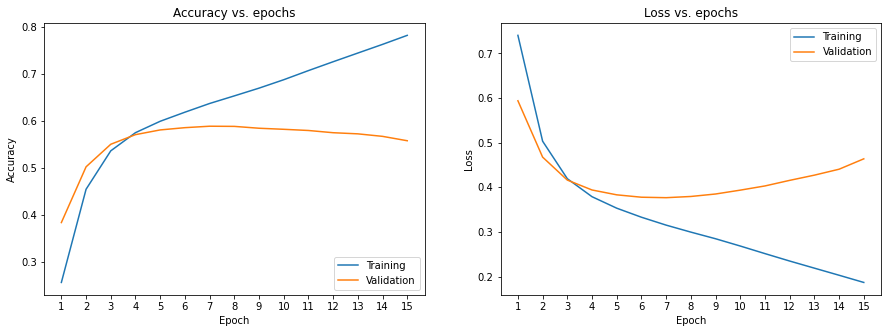

In [48]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_dict['sparse_categorical_accuracy'])
plt.plot(history_dict['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('models/LSTM_Loss_Acc_plot.png', dpi=300)
plt.show() 

#### Write a text generation algorithm

You can now use the model to generate text! In order to generate a single text sequence, the model needs to be rebuilt with a batch size of 1.

In [49]:
# Re-build the model and load the saved weights

model = get_model(len(tokenizer.word_index) +1  , batch_size=1)
model.load_weights(tf.train.latest_checkpoint('./models/'))

In [50]:
def get_logits(model, token_sequence, initial_state=[None,None]):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    token_sequence = np.array(token_sequence)
    if np.any(initial_state) is None:
      model.get_layer(index=1).reset_states()
    else: 
      model.get_layer(index=1).reset_states(states = initial_state)

    predictions = model(token_sequence)
    predictions = tf.squeeze(predictions, 0)
    return np.array(predictions)
    


**Hint:** you might find the `tf.random.categorical` function useful for this; see the documentation [here](https://www.tensorflow.org/api_docs/python/tf/random/categorical).

In [51]:
def sample_token(logits):
    """
    This function takes a 2D numpy array as an input, and constructs a 
    categorical distribution using it. It should then sample from this
    distribution and return the sample as a single integer.
    """
    
    sampled_index = tf.random.categorical(logits , num_samples=1)[-1,0].numpy()
    return int(sampled_index)

#### Generate text from the model

You are now ready to generate text from the model!

In [52]:
# Create a seed string and number of generation steps

init_string = 'Amir:'
num_generation_steps = 1000

In [53]:
# Use the model to generate a token sequence

token_sequence = tokenizer.texts_to_sequences([init_string])
initial_state1 = None
initial_state2 = None
input_sequence = token_sequence

for _ in range(num_generation_steps):
    logits = get_logits(model, input_sequence, initial_state=[initial_state1,initial_state2])
    sampled_token = sample_token(logits)
    token_sequence[0].append(sampled_token)
    input_sequence = [[sampled_token]]
    initial_state1 = model.layers[1].states[0].numpy()
    initial_state2 = model.layers[1].states[1].numpy()
    
print(tokenizer.sequences_to_texts(token_sequence)[0][::2])
with open('models/LSTM_output.txt', 'w') as file:
  file.write(tokenizer.sequences_to_texts(token_sequence)[0][::2])

Amir: no; I am all goes and
fellow; he may you forgoth practise, that sun, my goes,
Signior Outwarf's mindle parties can offended;
God save hinder desperation, pack of I,
Devour thy sovereignty it reason shall have
A fair-Officion of her, so swill by,
To have thy brother: so, but the poice of happy;
That laces leave to spect aught to such the lady?
My inclinots defect in the mockery; and the
gay you not, never, to 'now the nobility
To alter their wartings, as they have limen
Ere Ichalate to her that truitor's regons
By the people, yet as dissolute is moanded,
Than my busy and that posss of thousalt keen;
For I in godd, which, one that faults! I had renie?

ISABELLA:
How louse for resolutionst polixy ament,
And go rontoghe, goason, Gremio:
I cry this child to't; you that dote impolt'd
And how our humos! Why, say, strueghing; the king's
inequal my murdy, by accusent to goes,
And only tending on the thing is place,
And yet my subjects enement herl But lay,
To make umpass yield upon a will

# **GRU**

In [54]:


def get_model_GRU(vocab_size, batch_size):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    model = tf.keras.Sequential(
        [
         tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True, batch_input_shape=(batch_size, None)),
         tf.keras.layers.GRU(256,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
         tf.keras.layers.GRU(1024,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
         tf.keras.layers.GRU(2048,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
         tf.keras.layers.Dense(vocab_size)
        ]
    )
    
    return model
    

In [55]:
# Build the model and print the model summary

GRU_Model = get_model_GRU(len(tokenizer.word_index) + 1, batch_size)
GRU_Model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (32, None, 256)           16896     
_________________________________________________________________
gru_6 (GRU)                  (32, None, 256)           394752    
_________________________________________________________________
gru_7 (GRU)                  (32, None, 1024)          3938304   
_________________________________________________________________
gru_8 (GRU)                  (32, None, 2048)          18886656  
_________________________________________________________________
dense_6 (Dense)              (32, None, 66)            135234    
Total params: 23,371,842
Trainable params: 23,371,842
Non-trainable params: 0
_________________________________________________________________


In [56]:
skip_training = False

In [57]:
# Compile and train the model, or load pre-trained weights

if not skip_training:
    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./GRUmodels/ckpt',
                                                           save_weights_only=True,
                                                           save_best_only=True)
    GRU_Model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['sparse_categorical_accuracy'])
    history_GRU = GRU_Model.fit(train_data, epochs=15, validation_data=valid_data, 
                        validation_steps=50, callbacks=[checkpoint_callback])

Epoch 1/15
196/196 [==============================] - 351s 2s/step - loss: 0.8950 - sparse_categorical_accuracy: 0.1919 - val_loss: 0.5782 - val_sparse_categorical_accuracy: 0.4012
Epoch 2/15
196/196 [==============================] - 342s 2s/step - loss: 0.5235 - sparse_categorical_accuracy: 0.4412 - val_loss: 0.4505 - val_sparse_categorical_accuracy: 0.5187
Epoch 3/15
196/196 [==============================] - 341s 2s/step - loss: 0.4204 - sparse_categorical_accuracy: 0.5392 - val_loss: 0.4078 - val_sparse_categorical_accuracy: 0.5607
Epoch 4/15
196/196 [==============================] - 342s 2s/step - loss: 0.3746 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.3979 - val_sparse_categorical_accuracy: 0.5704
Epoch 5/15
196/196 [==============================] - 342s 2s/step - loss: 0.3448 - sparse_categorical_accuracy: 0.6105 - val_loss: 0.3959 - val_sparse_categorical_accuracy: 0.5745
Epoch 6/15
196/196 [==============================] - 341s 2s/step - loss: 0.3208 - sparse_cate

In [58]:
# Save model history as a json file, or load it if using pre-trained weights

if not skip_training:
    history_dict = dict()
    for k, v in history_GRU.history.items():
        history_dict[k] = [float(val) for val in history_GRU.history[k]]
    with open('GRUmodels/history.json', 'w+') as json_file:
        json.dump(history_dict, json_file, sort_keys=True, indent=4)
else:
    with open('GRUmodels/history.json', 'r') as json_file:
        history_dict = json.load(json_file)

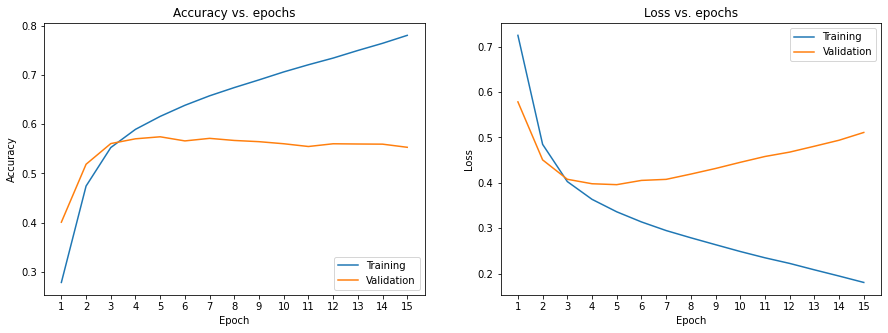

In [59]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_dict['sparse_categorical_accuracy'])
plt.plot(history_dict['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('GRUmodels/GRU_Loss_Acc.png', dpi=300)
plt.show() 

In [60]:
# Re-build the model and load the saved weights

GRU_Model = get_model_GRU(len(tokenizer.word_index) +1  , batch_size=1)
GRU_Model.load_weights(tf.train.latest_checkpoint('./GRUmodels/'))

In [61]:
def get_logits(model, token_sequence, initial_state=[None]):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    token_sequence = np.array(token_sequence)
    if np.any(initial_state) is None:
      model.get_layer(index=1).reset_states()
    else: 
      model.get_layer(index=1).reset_states(states = initial_state)

    predictions = model(token_sequence)
    predictions = tf.squeeze(predictions, 0)
    return np.array(predictions)
    

In [62]:
def sample_token(logits):
    """
    This function takes a 2D numpy array as an input, and constructs a 
    categorical distribution using it. It should then sample from this
    distribution and return the sample as a single integer.
    """
    
    sampled_index = tf.random.categorical(logits , num_samples=1)[-1,0].numpy()
    return int(sampled_index)

In [63]:
# Create a seed string and number of generation steps

init_string = 'Amir:'
num_generation_steps = 1000

In [64]:
# Use the model to generate a token sequence

token_sequence = tokenizer.texts_to_sequences([init_string])
initial_state1 = None
# initial_state2 = None
input_sequence = token_sequence

for _ in range(num_generation_steps):
    logits = get_logits(GRU_Model, input_sequence, initial_state=[initial_state1])
    sampled_token = sample_token(logits)
    token_sequence[0].append(sampled_token)
    input_sequence = [[sampled_token]]
    initial_state1 = GRU_Model.layers[1].states[0].numpy()
    # initial_state2 = model.layers[1].states[1].numpy()
    
print(tokenizer.sequences_to_texts(token_sequence)[0][::2])
with open('GRUmodels/GRU_output.txt','w') as file:
  file.write(tokenizer.sequences_to_texts(token_sequence)[0][::2])

Amir:
Take, night, and the prince,
Into a tilderness and spinition,
Aumer speak in the discorfers to you,
That laming, she is think you, traitor,
Or, roublions abidve were true, my son'st wail,
Thou art to bear, bay thou dear atvantage,
If they jalukely,
which made bear their seized means mark you, patness, fors
To break, and welcome a fight to quench as frain
It is toward Juleed till'dly flies,
And to the head, since you beloved are,
Welcome, myself a better hords, if not there you
Of bourn's up, thanks, O house not a melter,
Nasting like me: in gains alack, if she send the course,
She shake afford the name attending to me
They she not, by them, is we bode's arm, will reside
Seeming, kere all that, harded, upon the worse
She sway his early till I would awake a lovl'd wall
Being cauted, stand, ladius: let me hadf a man to him,
And follow they music and a sail and imadimerh
To have the aim, would and my breathest that Romeo:
These gawns ambights I'll not be thinking
To whine's willings 

# **Combine LSTM and GRU**

In [65]:
def get_modelGL(vocab_size, batch_size):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    model = tf.keras.Sequential(
        [
         tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True, batch_input_shape=(batch_size, None)),
         tf.keras.layers.LSTM(1024,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
         tf.keras.layers.GRU(256,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
         tf.keras.layers.LSTM(64,return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),

         tf.keras.layers.Dense(vocab_size)
        ]
    )
    
    return model
    

In [66]:
# Build the model and print the model summary

modelGL = get_modelGL(len(tokenizer.word_index) + 1, batch_size)
modelGL.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (32, None, 256)           16896     
_________________________________________________________________
lstm_6 (LSTM)                (32, None, 1024)          5246976   
_________________________________________________________________
gru_12 (GRU)                 (32, None, 256)           984576    
_________________________________________________________________
lstm_7 (LSTM)                (32, None, 64)            82176     
_________________________________________________________________
dense_8 (Dense)              (32, None, 66)            4290      
Total params: 6,334,914
Trainable params: 6,334,914
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Choose whether to train a new model or load the pre-trained model

skip_training = False

In [68]:
# Compile and train the model, or load pre-trained weights

if not skip_training:
    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./GL_models/ckpt',
                                                           save_weights_only=True,
                                                           save_best_only=True)
    modelGL.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['sparse_categorical_accuracy'])
    historyGL = modelGL.fit(train_data, epochs=15, validation_data=valid_data, 
                        validation_steps=50, callbacks=[checkpoint_callback])

Epoch 1/15
196/196 [==============================] - 273s 1s/step - loss: 0.9398 - sparse_categorical_accuracy: 0.1496 - val_loss: 0.9186 - val_sparse_categorical_accuracy: 0.1534
Epoch 2/15
196/196 [==============================] - 261s 1s/step - loss: 0.9000 - sparse_categorical_accuracy: 0.1537 - val_loss: 0.9183 - val_sparse_categorical_accuracy: 0.1534
Epoch 3/15
196/196 [==============================] - 261s 1s/step - loss: 0.8859 - sparse_categorical_accuracy: 0.1619 - val_loss: 0.7746 - val_sparse_categorical_accuracy: 0.2627
Epoch 4/15
196/196 [==============================] - 261s 1s/step - loss: 0.7141 - sparse_categorical_accuracy: 0.2891 - val_loss: 0.6293 - val_sparse_categorical_accuracy: 0.3654
Epoch 5/15
196/196 [==============================] - 262s 1s/step - loss: 0.5954 - sparse_categorical_accuracy: 0.3851 - val_loss: 0.5534 - val_sparse_categorical_accuracy: 0.4318
Epoch 6/15
196/196 [==============================] - 261s 1s/step - loss: 0.5265 - sparse_cate

In [69]:
# Save model history as a json file, or load it if using pre-trained weights

if not skip_training:
    history_dict = dict()
    for k, v in historyGL.history.items():
        history_dict[k] = [float(val) for val in historyGL.history[k]]
    with open('GL_models/historyGL.json', 'w+') as json_file:
        json.dump(history_dict, json_file, sort_keys=True, indent=4)
else:
    with open('GL_models/historyGL.json', 'r') as json_file:
        history_dict = json.load(json_file)

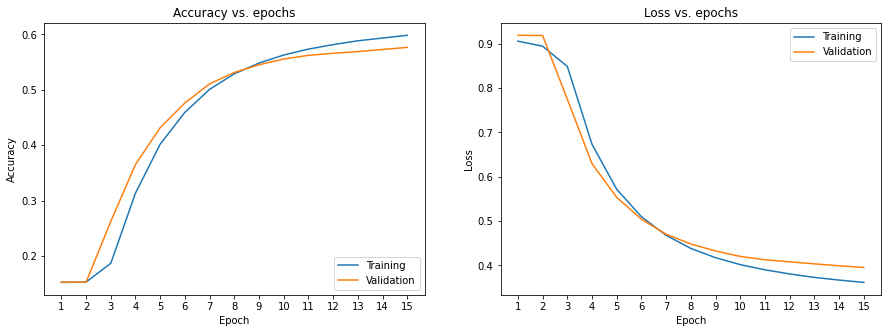

In [70]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_dict['sparse_categorical_accuracy'])
plt.plot(history_dict['val_sparse_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
ax = plt.gca()
ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('GL_models/GL_Loss_Accuracy.png')
plt.show() 

In [71]:
# Re-build the model and load the saved weights

modelGL = get_modelGL(len(tokenizer.word_index) +1  , batch_size=1)
modelGL.load_weights(tf.train.latest_checkpoint('./GL_models/'))

In [80]:
def get_logits(model, token_sequence, initial_state=[None,None]):
    """
    This function takes a model object, a token sequence and an optional initial
    state for the recurrent layer. The function should return the logits prediction
    for the final time step as a 2D numpy array.
    """
    token_sequence = np.array(token_sequence)
    if np.any(initial_state) is None:
      model.get_layer(index=1).reset_states()
    else: 
      model.get_layer(index=1).reset_states(states = initial_state)

    predictions = model(token_sequence)
    predictions = tf.squeeze(predictions, 0)
    return np.array(predictions)
    

In [81]:
def sample_token(logits):
    """
    This function takes a 2D numpy array as an input, and constructs a 
    categorical distribution using it. It should then sample from this
    distribution and return the sample as a single integer.
    """
    
    sampled_index = tf.random.categorical(logits , num_samples=1)[-1,0].numpy()
    return int(sampled_index)

In [82]:
# Create a seed string and number of generation steps

init_string = 'Amir:'
num_generation_steps = 1000

In [83]:
# Use the model to generate a token sequence

token_sequence = tokenizer.texts_to_sequences([init_string])
initial_state1 = None
initial_state2 = None
input_sequence = token_sequence

for _ in range(num_generation_steps):
    logits = get_logits(model, input_sequence, initial_state=[initial_state1,initial_state2])
    sampled_token = sample_token(logits)
    token_sequence[0].append(sampled_token)
    input_sequence = [[sampled_token]]
    initial_state1 = model.layers[1].states[0].numpy()
    initial_state2 = model.layers[1].states[1].numpy()
    
print(tokenizer.sequences_to_texts(token_sequence)[0][::2])
with open('GL_models/LSTM_output.txt', 'w') as file:
  file.write(tokenizer.sequences_to_texts(token_sequence)[0][::2])

Amir: informy, by prince
More enough I benish you: as a fleen,
Tagural is the wry the prince of York,
And nof so dull a day abucely;
Now, on, fair carbent, to anither each
Tradioly in your soldier,
A bawdon much best days and end themselves?

NLOUCESTER:
Commends you for her heart black, I will think,
That waming, So, yield against Clifford,
To do some walliance that say'lt-sturp'd dun,
And being outward teeper, or no could deceive
But sweet from one that which to daughter's truth:
But when so thranks Bianca not her county
If the despiring open thing it women
to end it the parlor and your furwer'd saintness,
Some ill--uported back aborthing on my head,
Owing to't, nor is gone more to your happs,
If straight what makes the low God Romeo?

HENREY PORI

CATESBY:
He will, my liege I'll speak what I can no seal
Now, what awazentmaning opposers;
Your waitles places: then in thy gromings
Are thou gone, here, sleeply knew the Air;
And your awquired there, pray you, and I am points,
And what tr